# Bag of Words model

Here we train and test a Bag of Words model to predict helpful notes on
Birdwatch.

In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from scipy.sparse import hstack
from sklearn.ensemble import GradientBoostingClassifier
from collections import OrderedDict
import shap
from tqdm import tqdm
from joblib import dump

from core_functions import evaluate_model

In [2]:
train_data = pd.read_csv('../data/processed/training_data.csv')
val_data = pd.read_csv('../data/processed/val_data.csv')
test_data = pd.read_csv('../data/processed/test_data.csv')

### Featurization

In [3]:
datasets = OrderedDict([('train', {'notes': train_data.iloc[:,:22].drop_duplicates().reset_index(drop=True),
                                   'notes_ratings': train_data}),
                        ('val', {'notes': val_data.iloc[:, :22].drop_duplicates().reset_index(drop=True),
                                 'notes_ratings': val_data}),
                        ('test', {'notes': test_data.iloc[:, :22].drop_duplicates().reset_index(drop=True),
                                  'notes_ratings': test_data})])

In [4]:
feature_names = []
for name, data_dict in tqdm(datasets.items(), total=3):
    notes_df = data_dict['notes']
    notes_ratings_df = data_dict['notes_ratings']

    if name == 'train':
        mono_vectorizer_summary = CountVectorizer(max_features=4000)
        mono_vectorizer_summary.fit(notes_df['summary'])
        feature_names.extend(mono_vectorizer_summary.get_feature_names_out())
    mono_X_summary = mono_vectorizer_summary.transform(notes_df['summary'])

    if name == 'train':
        bi_vectorizer_summary = CountVectorizer(max_features=4000, ngram_range=(2, 2))
        bi_vectorizer_summary.fit(notes_df['summary'])
        feature_names.extend(bi_vectorizer_summary.get_feature_names_out())
    bi_X_summary = bi_vectorizer_summary.transform(notes_df['summary'])

    sparse_X = hstack([mono_X_summary, bi_X_summary])
    X_df = pd.DataFrame(sparse_X.todense())
    X_df['noteId'] = notes_df['noteId']
    merged_X_df = X_df.merge(notes_ratings_df[['noteId', 'output', 'scaling']],
                             how='inner', on='noteId')
    X = scipy.sparse.csr_matrix(merged_X_df.drop(['noteId', 'output', 'scaling'], axis=1))
    datasets[name]['X'] = X
    datasets[name]['Y'] = merged_X_df['output']
    datasets[name]['scaling'] = merged_X_df['scaling']
    datasets[name]['noteId'] = merged_X_df['noteId']
    print(name, 'size', merged_X_df.shape[0])

 33%|███▎      | 1/3 [00:56<01:53, 56.59s/it]

train size 88185


 67%|██████▋   | 2/3 [00:59<00:25, 25.20s/it]

val size 11641


100%|██████████| 3/3 [01:03<00:00, 21.09s/it]

test size 10507


In [5]:
datasets['test']['Y'].sum()/len(datasets['test']['Y'])

0.6603216903017036

In [6]:
model = GradientBoostingClassifier(random_state=7, verbose=1)
model.fit(datasets['train']['X'], datasets['train']['Y'],
          sample_weight=datasets['train']['scaling'])


      Iter       Train Loss   Remaining Time 
         1           1.2910           17.40s
         2           1.2809           15.71s
         3           1.2727           14.79s
         4           1.2660           14.46s
         5           1.2605           14.23s
         6           1.2559           13.88s
         7           1.2520           13.67s
         8           1.2489           13.41s
         9           1.2460           13.19s
        10           1.2436           12.98s
        20           1.2297           11.32s
        30           1.2217            9.75s
        40           1.2157            8.28s
        50           1.2104            6.90s
        60           1.2060            5.50s
        70           1.2016            4.10s
        80           1.1974            2.72s
        90           1.1935            1.35s
       100           1.1902            0.00s


GradientBoostingClassifier(random_state=7, verbose=1)

In [7]:
for name, data_dict in datasets.items():
    predictions = model.predict(data_dict['X'])
    p_hat = model.predict_proba(data_dict['X'])[:, 1]
    observations = data_dict['Y']
    scaling = data_dict['scaling']
    performance_dict = evaluate_model(predictions, p_hat, observations,
                                      scaling, name)
    data_dict['Y_hat'] = predictions
    data_dict['p_hat'] = p_hat
    data_dict['performance'] = performance_dict

In [8]:
performance_metrics = []
for name, data_dict in datasets.items():
    performance_metrics.append(data_dict['performance'])
performance_metrics_df = pd.DataFrame(performance_metrics)
performance_metrics_df

,accuracy,f1,precision,recall,roc-auc,avg_precision,name
0,0.686289,0.781485,0.707585,0.872621,0.717342,0.815078,train
1,0.668018,0.767519,0.689992,0.864673,0.663116,0.752398,val
2,0.656928,0.758216,0.692243,0.838090,0.649306,0.755782,test


We'll output the model anlong with featurizers

In [10]:
dump(model, '../data/models/bow/gb_model.joblib')
dump(mono_vectorizer_summary, '../data/models/bow/mono_vectorizer.joblib')
dump(bi_vectorizer_summary, '../data/models/bow/bi_vectorizer.joblib')

['../data/models/bow/bi_vectorizer.joblib']

### Feature Importance

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(datasets['train']['X'].todense())

In [10]:
shap_values_df = pd.DataFrame(shap_values.values, columns=feature_names)
feature_df = pd.DataFrame(shap_values.data, columns=feature_names)

In [11]:
feat_summary = (shap_values_df.abs().mean(axis=0)
                .reset_index(name='avg_abs_shap')
                .rename({'index': 'feat'}, axis=1)
                .sort_values('avg_abs_shap', ascending=False))
top_features = feat_summary.head(20).reset_index(drop=True)

In [12]:
for i, row in tqdm(top_features.iterrows(), total=len(top_features)):
    if (shap_values_df[row['feat']].nunique() > 1):
        top_features.at[i, 'r'] = np.corrcoef(feature_df[row['feat']],
                                              shap_values_df[row['feat']])[0, 1]
        top_features.at[i, 'n_nonzero'] = (feature_df[row['feat']] > 0).sum()
    else:
        top_features.at[i, 'r'] = 0

100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


In [13]:
top_features

,feat,avg_abs_shap,r,n_nonzero
0,https,0.374783,0.732813,56235.0
1,the,0.055651,0.650075,62160.0
2,this,0.049081,0.892104,28164.0
3,www,0.040680,0.826214,38370.0
4,article,0.016718,0.897333,7367.0
5,according,0.014260,0.973381,1769.0
6,covid,0.013306,0.782979,12184.0
7,photo,0.011293,0.936914,1179.0
8,in,0.010344,0.770337,32580.0
9,factchecks 2021,0.009356,0.990133,749.0


Here we output a table of features for Latex

In [14]:
print(top_features[['feat', 'avg_abs_shap', 'r']]
 .rename({'feat': 'Feature',
          'avg_abs_shap': 'SHAP value',
          'r': 'SHAP correlation'}, axis=1)
 .head(10).to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrr}
\toprule
        Feature &  SHAP value &  SHAP correlation \\
\midrule
          https &       0.375 &             0.733 \\
            the &       0.056 &             0.650 \\
           this &       0.049 &             0.892 \\
            www &       0.041 &             0.826 \\
        article &       0.017 &             0.897 \\
      according &       0.014 &             0.973 \\
          covid &       0.013 &             0.783 \\
          photo &       0.011 &             0.937 \\
             in &       0.010 &             0.770 \\
factchecks 2021 &       0.009 &             0.990 \\
\bottomrule
\end{tabular}



In [15]:
shap_values_df.sort_values('the', ascending=False).head()

,000,01,011,02,021,03,04,05,06,07,...,you re,you should,you to,you will,your civil,your dna,youtu be,youtube com,zero dollars,zero evidence
41083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.280420e-07,0.0,0.0
41075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.280420e-07,0.0,0.0
41082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.280420e-07,0.0,0.0
41084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.280420e-07,0.0,0.0
41085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.280420e-07,0.0,0.0


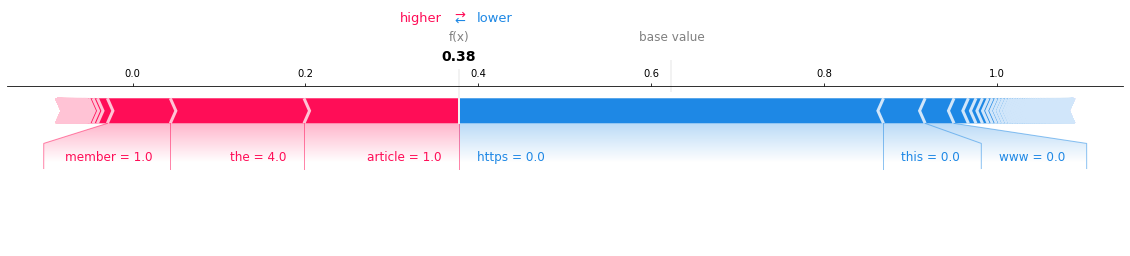

'Read the article. The person who ran over someone was a member of the LGBTQ choir. The whole thing was an accident.'

In [16]:
feat_i = 41083
shap.plots.force(float(shap_values.base_values[feat_i]),
                 shap_values.values[feat_i],
                 np.asarray(shap_values.data[feat_i, :]),
                 matplotlib=True,
                 feature_names=feature_names)
sample_note_id = datasets['train']['noteId'][feat_i]
notes_df = datasets['train']['notes']
notes_df[notes_df['noteId'] == sample_note_id]['summary'].values[0]